In [ ]:
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")

# uplifitng

### Îç∞Ïù¥ÌÑ∞ Î≥ÄÏàò ÏÑ§Î™Ö
* recency : ÎßàÏßÄÎßâ Íµ¨Îß§ ÌõÑ Í∞úÏõî
* history: Í≥ºÍ±∞ Íµ¨Îß§Ïùò $value
* used_discount: Ìï†Ïù∏ ÏÇ¨Ïö© Ïó¨Î∂Ä
* used_bogo: Ïû¨Íµ¨Îß§ ÌñàÎäîÏßÄ Ïó¨Î∂Ä
* zip_code: Suburban/Urban/RuralÍ≥º Í∞ôÏùÄ Ïö∞Ìé∏Î≤àÌò∏ ÌÅ¥ÎûòÏä§
* is_referral: Ï∂îÏ≤ú Ï±ÑÎÑêÏóêÏÑú Í≥†Í∞ùÏùÑ ÌöçÎìùÌñàÎäîÏßÄ Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÉÖÎãàÎã§.
* channel: Í≥†Í∞ùÏù¥ ÏÇ¨Ïö©ÌïòÎäî Ï±ÑÎÑê, Phone/Web/Multichannel
* offer: Í≥†Í∞ùÏóêÍ≤å Ï†ÑÏÜ°Îêú Ï†úÏïà, Discount/But One Get One(ÏõêÌîåÎü¨Ïä§Ïõê)/No Offer
* conversation : (1-Íµ¨Îß§ , 0-X)

### Content

This dataset show customer's brief information,
historical use of discount or BOGO(Buy One Get One) promotion,
offer has been made, and the conversion result(buy or not).
The conversion average value = $25

----
Îç∞Ïù¥ÌÑ∞ ÏÑ§Î™ÖÏóê Îî∞Î•¥Î©¥ discount ÎÇò bogo offerÎ•º Î∞õÏùÄ Í≥†Í∞ùÎì§ÏùÄ Treatment(ÌÉÄÍ≤üÍµ∞) Ïù¥Í≥† ÎÇòÎ®∏ÏßÄÎäî ÌÜµÏ†úÏßëÎã®ÏúºÎ°ú Î≥º Ïàò ÏûàÍ≤†Îã§.


In [ ]:
# !kaggle datasets download -d davinwijaya/customer-retention
!unzip -o /content/customer-retention.zip -d /content

Archive:  /content/customer-retention.zip
  inflating: /content/data.csv       


In [110]:
df= pd.read_csv('/content/uplift.csv')

In [ ]:
df

recency  history  used_discount  used_bogo   zip_code  is_referral  \
0           10   142.44              1          0  Surburban            0   
1            6   329.08              1          1      Rural            1   
2            7   180.65              0          1  Surburban            1   
3            9   675.83              1          0      Rural            1   
4            2    45.34              1          0      Urban            0   
...        ...      ...            ...        ...        ...          ...   
63995       10   105.54              1          0      Urban            0   
63996        5    38.91              0          1      Urban            1   
63997        6    29.99              1          0      Urban            1   
63998        1   552.94              1          0  Surburban            1   
63999        1   472.82              0          1  Surburban            0   

            channel            offer  conversion  
0             Phone  Buy One Get One           0  
1               Web         No Offer           0  
2               Web  Buy One Get One           0  
3               Web         Discount           0  
4               Web  Buy One Get One           0  
...             ...              ...         ...  
63995           Web         Discount           0  
63996         Phone         Discount           0  
63997         Phone         Discount           0  
63998  Multichannel  Buy One Get One           0  
63999           Web         Discount           0  

[64000 rows x 9 columns]

# Îç∞Ïù¥ÌÑ∞ÌÉêÏÉâ

In [ ]:
df.info()

In [ ]:
# Î≤îÏ£ºÌòï Î≥ÄÏàò ÌôïÏù∏
df.describe(include = np.object)

zip_code channel            offer
count       64000   64000            64000
unique          3       3                3
top     Surburban     Web  Buy One Get One
freq        28776   28217            21387

In [ ]:
# Î™ÖÎ™©Ìòï Î≥ÄÏàò Í∞íÎì§ count /  Îç∞Ïù¥ÌÑ∞ÏÑ§Î™ÖÏóê Î™ÖÏãúÎêú Í≤É ÎßêÍ≥† Ïù¥Ïô∏Ïùò Í∞íÏù¥ ÏûàÎÇò ÌôïÏù∏Ìï¥Î≥¥Ïûê
zip_count = df['zip_code'].value_counts()
channel_count = df['channel'].value_counts()
offer_count = df['offer'].value_counts()

print(zip_count)
print(channel_count)
print(offer_count)



Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


In [111]:
# Ìé∏ÏùòÏÉÅ conversion ÏùÑ target ÏúºÎ°ú
# offer Î•º treatmentÎ°ú Î∞îÍøîÏ£ºÏûê.

df = df.rename(columns={'conversion': 'target','offer':'treatment'})
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1}) # 0 Ïù∏Í≤ΩÏö∞ control, -1,1 Ïù∏Í≤ΩÏö∞ Treatment


* treatment(-1) = BOGO ÏõêÌîåÎü¨Ïä§Ïõê Í¥ëÍ≥†Î•º Î∞õÏùÄ Ïã§ÌóòÍµ∞
* treatment(1) = Ìï†Ïù∏ Í¥ëÍ≥†Î•º Î∞õÏùÄ Ïã§ÌóòÍµ∞
* treatment(0) = ÎåÄÏ°∞Íµ∞



In [113]:
df['treatment'].value_counts()

-1    21387
 1    21307
 0    21306
Name: treatment, dtype: int64

In [114]:
# Î≤îÏ£ºÌòï Î≥ÄÏàò one hot encoding
df_model = pd.get_dummies(df)


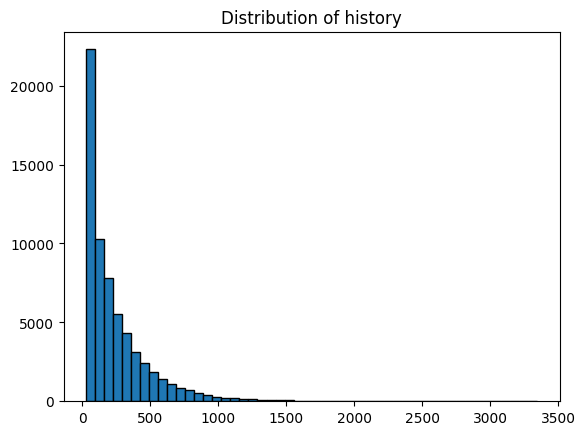

In [ ]:
# recency  history
# ÌûàÏä§ÌÜ†Î¶¨Ïùò Í≤ΩÏö∞ Ïñ¥ÎäêÏ†ïÎèÑ Ïù¥ÏÉÅÏπòÍ∞íÏù¥ ÏûàÎã§.
import matplotlib.pyplot as plt

plt.hist(df['history'], bins=50, edgecolor='black')  # 20Í∞úÏùò Íµ¨Í∞ÑÏúºÎ°ú ÎÇòÎàÑÏñ¥ ÌûàÏä§ÌÜ†Í∑∏Îû® Í∑∏Î¶¨Í∏∞
plt.title('Distribution of history')
plt.show()

In [115]:
# target Î≥ÄÏàò
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True) # ÏõêÌîåÏõê Í¥ëÍ≥†Î•º Î∞õÏùÄ Ïã§ÌóòÍµ∞Í≥º ÎåÄÏ°∞Íµ∞ DATA
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True) # Ìï†Ïù∏ Í¥ëÍ≥†Î•º Î∞õÏùÄ Ïã§ÌóòÍµ∞Í≥º ÎåÄÏ°∞Íµ∞ DATA

In [116]:
df_model_bogo['treatment'] = df_model_bogo['treatment'].replace(-1, 1)

In [124]:
df_model['treatment'] = df_model['treatment'].replace(-1,1)

## 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities. The calibration of model probabilities is described perfectly in [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Two independent models

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

1. Train the first model using the treatment set.
2. Train the second model using the control set.
3. Inference: subtract the control model scores from the treatment model scores.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila.png" alt="Two Models vanila"/>
</p>

In [125]:
train, test  = train_test_split(df_model, test_size=0.2, random_state=42, stratify = df_model['treatment'])

# Ï£ºÏñ¥ÏßÑ ÌîºÏ≤ò Î¶¨Ïä§Ìä∏
features = ['recency',	'history',	'used_discount',	'used_bogo',	'is_referral'	,	'zip_code_Rural',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Multichannel',	'channel_Phone'	,'channel_Web']

# ÌîºÏ≤ò Î∞è ÌÉÄÍ≤üÏùÑ ÏÑ§Ï†ïÌïòÍ≥† Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÌï†
X = train[features]  # train Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌîºÏ≤ò Ï∂îÏ∂ú
y = train['target']
treatment = train['treatment']

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

[LightGBM] [Info] Number of positive: 1450, number of negative: 12249
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 13699, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.105847 -> initscore=-2.133881
[LightGBM] [Info] Start training from score -2.133881
[LightGBM] [Info] Number of positive: 4539, number of negative: 22722
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 27261, number of used features: 11
[LightGBM] [Info

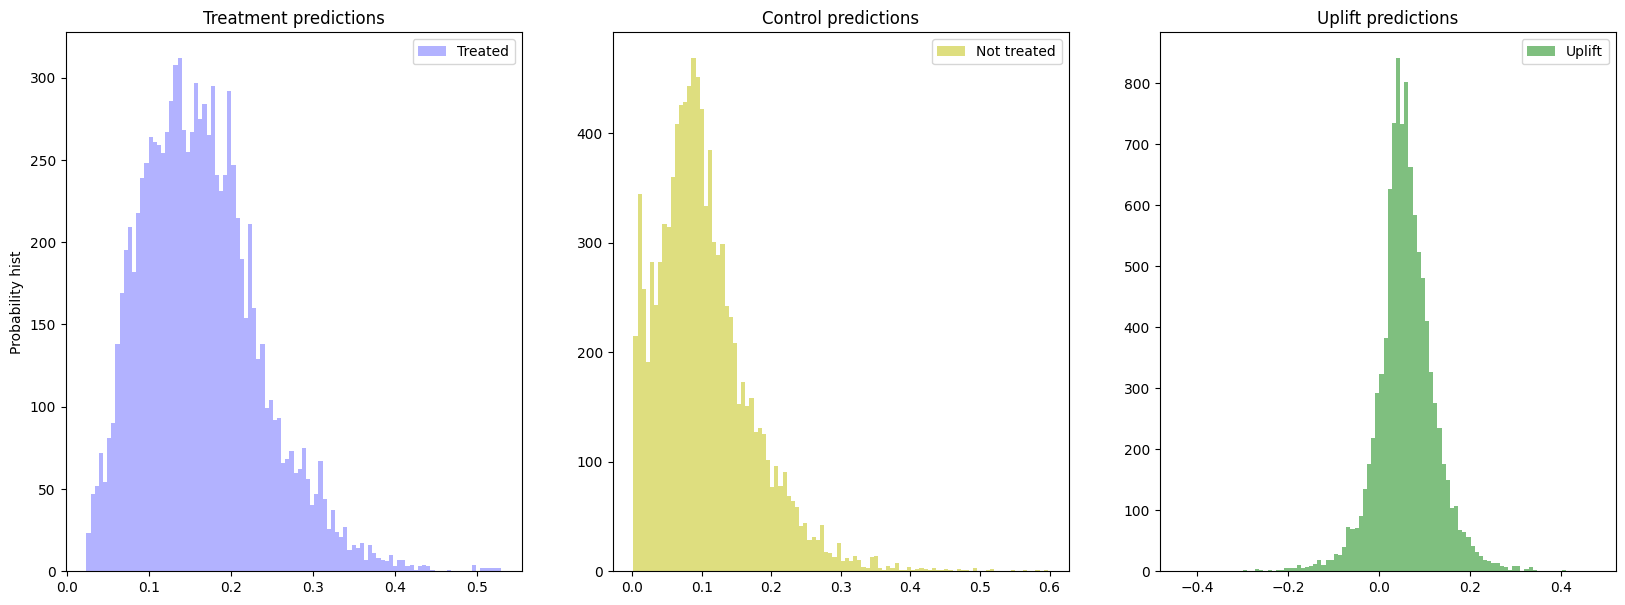

In [126]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss'
}

# TwoModels Î™®Îç∏ ÏÑ§Ï†ï
tm = TwoModels(
    estimator_trmnt=lgb.LGBMClassifier(**lgb_params),
    estimator_ctrl=lgb.LGBMClassifier(**lgb_params),
    method='vanilla'
)

# 3. Î™®Îç∏ ÌïôÏäµ
tm = tm.fit(
    X_train, y_train, treat_train
)

# 4. ÏóÖÎ¶¨ÌîÑÌåÖ ÏòàÏ∏°
uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

# 5. ÏóÖÎ¶¨ÌîÑÌåÖ Ï∏°Ï†ï
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

approach  uplift@30%
0  TwoModels    0.073687

In [ ]:
df_uplift = pd.DataFrame({'uplift_score': np.array(uplift_tm)})
df_uplift

uplift_score
0         0.031237
1         0.001270
2        -0.054862
3         0.072842
4         0.084649
...            ...
6813      0.089104
6814      0.103594
6815     -0.036275
6816      0.299455
6817      0.095484

[6818 rows x 1 columns]

In [127]:
df_model = df_model[features]

In [128]:
uplift_full = tm.predict(df_model)  # Ï†ÅÏö©
df_model['score'] = uplift_full

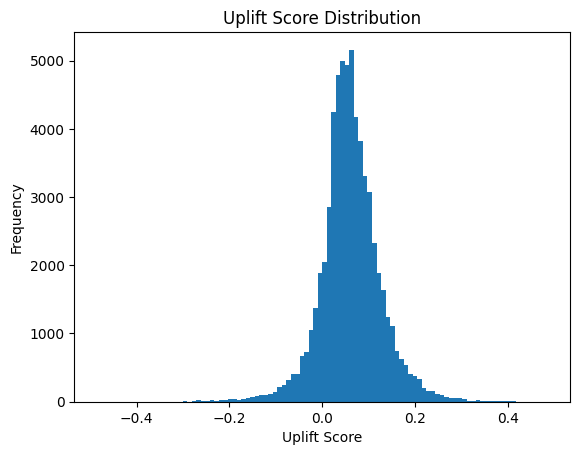

In [130]:
plt.hist(df_model['score'], bins=100)
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Uplift Score Distribution')
plt.show()

In [154]:
#CN:
df['target_class'] = 0
#CR:
df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1
#TN:
df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2
#TR:
df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3

df['target_class'].value_counts()

2    35562
0    19044
3     7132
1     2262
Name: target_class, dtype: int64

In [134]:
# score Í∞Ä 0 Ïù¥ÏÉÅÏù∏

score_count = df_model[df_model['score'] >= 0]['score'].count()
total_count = len(df_model)

positive_score_ratio = score_count / total_count
print("Positive Score Ratio:", positive_score_ratio)


Positive Score Ratio: 0.871734375


In [160]:
# ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï
threshold = 0

# Pesuadables Í∑∏Î£πÏúºÎ°ú Í∞ÑÏ£ºÎêòÎäî Îç∞Ïù¥ÌÑ∞ Í∞úÏàò Í≥ÑÏÇ∞
pesuadables_count = len(df_model[df_model['score'] >= threshold])

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò
total_count = len(df_model)

# Pesuadables Í∑∏Î£πÏùò ÎπÑÏú® Í≥ÑÏÇ∞
pesuadables_ratio = pesuadables_count / total_count

print("Pesuadables Í∑∏Î£π ÎπÑÏú®:", pesuadables_ratio)

Pesuadables Í∑∏Î£π ÎπÑÏú®: 0.0143125


###  scoreÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏÑ∏Í∑∏Î®ºÌä∏Î•º Ïñ¥ÎñªÍ≤å ÎÇòÎà†ÏïºÌïòÏßÄ?

>‚úîÔ∏è skewness Îäî ÎÜíÏßÄ ÏïäÏßÄÎßå ÏïΩ 87% Ïú†Ï†ÄÏùò scoreÍ∞Ä 0.0 Ïù¥ÏÉÅÏùÑ Í∏∞Î°ùÌñàÎã§.
ÏóÖÎ¶¨ÌîÑÌåÖ ÏÇ¨Î∂ÑÎ©¥Ïóê Îî∞Îùº ÏÑ∏Í∑∏Î®ºÌÑ∞Î•º ÎÇòÎà†ÏïºÌïòÎäîÎç∞, Ïñ¥Îñ§ Í∏∞Ï§ÄÏúºÎ°ú ÎÇòÎà†ÏïºÌï†Íπå..?

> score Í∞Ä ÎÜíÏùÑ ÏàòÎ°ù Pesuadables Í≥†Í∞ùÏúºÎ°ú Î¥êÏïºÌïòÎäîÍ≤É Í∞ôÏùÄÎç∞  Í∑∏ ÎÜíÎã§Îäî Í∏∞Ï§ÄÏùÑ Ïñ¥ÎîîÎ°ú Ïû°ÏïÑÏïº ÌïòÎäîÏßÄ Ìó∑Í∞àÎ¶∞Îã§!

### ü§îÍ≤∞Î°†!
ÏùºÎã® ÌÅ¨Í≤å ÏπòÏö∞Ï≥êÏßÄÏßÄ ÏïäÍ≥†,
* score Í∞Ä 0 Ïù¥ÏÉÅÏù∏Í≤ΩÏö∞ 87%
* 0.1 Ïù∏Í≤ΩÏö∞, 23%
* 0.2 Ïù∏ Í≤ΩÏö∞ 2.5%
* 0.3 Î∂ÄÌÑ∞Îäî 0.2 %Î°ú Îß§Ïö∞ Ï†ÅÎã§.
* scroeÍ∞Ä ÏùåÏàòÏù∏ Í≤ΩÏö∞Îäî 13% Í∞Ä ÏûàÏùå.

ÌÅ¨Í≤å 4Í∞ÄÏßÄÎ°ú Î∂ÑÎ•òÌï† Ïàò Îäî ÏóÜÏùÑ Í≤É Í∞ôÏßÄÎßå, ÌôïÏã§ÌïúÍ±¥ Ìï¥Îãπ Í¥ëÍ≥†Ïãú Î∂ÄÏ†ïÏ†ÅÏù∏ ÏòÅÌñ•ÏùÑ ÎÅºÏπ† ÏÑ∏Í∑∏Î®ºÌä∏Îäî ÌôïÏã§Ìûà ÎÇòÎàå Ïàò ÏûàÎã§ÎäîÍ≤É!

> ÏùºÎã®ÏùÄ 0 =< surething < 0.1  Ïù∏Í≤ΩÏö∞ SureThings \
0.1 Ïù¥ÏÉÅÏù∏Í≤ΩÏö∞ Persuadables , ÏùåÏàòÏù∏Í≤ΩÏö∞ Lost Causes Î°ú ÎÇòÎàÑÏóàÎã§.



In [162]:
def segment_customers(score):
    if score >= 0 and score < 0.1:
        return "Sure Things"
    elif score >= 0.1:
        return "Persuadables"
    elif score >= -0.1 and score < 0:
        return "Lost Causes"
    else:
        return "Sleeping dogs"

df_model['segment'] = df_model['score'].apply(segment_customers)
df_model['segment'].value_counts()

Sure Things      41285
Persuadables     14506
Lost Causes       7293
Sleeping dogs      916
Name: segment, dtype: int64

In [136]:
df_model['segment'].value_counts()

Sure Things      55791
Sleeping Dogs     8209
Name: segment, dtype: int64

# New  Data

Îç∞Ïù¥ÌÑ∞Í∞Ä ÎÑàÎ¨¥ ÌÅ¨Îã§. kaggle apiÎ°ú Î∞õÏïÑÏò§Ïûê

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omgcs7750","key":"8be0431ae68897c04d1934bc7669c90c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arashnic/uplift-modeling

 96% 313M/324M [00:01<00:00, 256MB/s]
100% 324M/324M [00:01<00:00, 233MB/s]


In [ ]:
!unzip -o /content/uplift-modeling.zip -d /content

Archive:  /content/uplift-modeling.zip
  inflating: /content/criteo-uplift-v2.1.csv  


In [ ]:
df = pd.read_csv('/content/criteo-uplift-v2.1.csv')


# data info (binary)

* treatment (1) : Ïã§ÌóòÍµ∞, target
* treatment (0) : ÎåÄÏ°∞Íµ∞, control

* conversion : Ï†ÑÌôò Ïó¨Î∂Ä
* visit : Î∞©Î¨∏Ïó¨Î∂Ä
* exposure : ÎÖ∏Ï∂úÏó¨Î∂Ä? Ïù∏Îç∞ Í¥ëÍ≥† ÎÖ∏Ï∂úÏùÑ Î∞õÏùÄÍ±∏ ÏùòÎØ∏ÌïòÎäîÍ≤É Í∞ôÎã§. treatment effect, whether the user has been effectively exposed . Ï¶â Ï∫†ÌéòÏù∏, ÎßàÏºÄÌåÖÏùÑ Î∞õÏïòÎäîÏßÄ

treatment Ïùò Í≤ΩÏö∞ treatment ÏôÄ control Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ¥Îäî Î≥ÄÏàò Ïù¥Î©∞
exposure ÏùÄ ÏôÑÎ≤ΩÌïòÍ≤å ÎßàÏºÄÌåÖ Í¥ëÍ≥†Ïóê ÎÖ∏Ï∂úÎêòÏóàÎäîÏßÄ Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ∏Îã§.

ÏúÑ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ïã§ÌóòÍµ∞ Ïù¥ÏßÄÎßå ÎÖ∏Ï∂úÏùÑ Î∞õÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ÎèÑ ÏûàÎã§. Ìé∏ÏùòÏÉÅ  exposure ÍπåÏßÄ Î∞õÏïòÏùÑ Îïå, treatment ÎùºÍ≥† Ìï¥ÏïºÌï†Í≤É Í∞ôÎã§. Ï¶â, exposure =1 treatment =1 Ïù∏ Í≤ΩÏö∞ Î•º treatment Î°ú





In [ ]:
df.sample(100)

f0         f1        f2        f3         f4        f5  \
9168545   12.616365  10.059654  8.983713  4.679882  10.280525  4.115453   
10715628  14.523018  10.059654  8.338012  3.907662  10.280525  4.115453   
6490181   22.683053  10.059654  8.214383  4.679882  10.280525  4.115453   
9697044   25.925363  10.059654  8.349674  4.679882  10.280525  4.115453   
9936232   23.966730  10.059654  8.632747  4.679882  10.280525  4.115453   
...             ...        ...       ...       ...        ...       ...   
1841188   23.459432  10.059654  8.789075  4.679882  10.280525  4.115453   
2222041   23.354885  10.059654  8.214383  4.679882  10.280525  4.115453   
1784564   23.171974  10.059654  8.214383  4.679882  10.280525  4.115453   
10428883  26.691794  10.059654  8.214383  4.679882  10.280525  4.115453   
5766535   22.784314  10.059654  8.232660  4.679882  12.310110  4.115453   

                 f6        f7        f8         f9       f10       f11  \
9168545    0.294443  4.833815  3.843683  13.190056  5.300375 -0.168679   
10715628  -1.288207  4.833815  3.858041  33.712556  5.300375 -0.168679   
6490181   -2.411115  4.833815  3.971858  13.190056  5.300375 -0.168679   
9697044   -1.288207  4.833815  3.955396  16.226044  5.300375 -0.168679   
9936232   -8.281971  4.833815  3.861910  21.416100  5.300375 -0.168679   
...             ...       ...       ...        ...       ...       ...   
1841188   -3.282109  4.833815  3.927254  13.190056  5.300375 -0.168679   
2222041  -10.275874  4.833815  3.971858  13.190056  5.300375 -0.168679   
1784564   -1.288207  4.833815  3.971858  13.190056  5.300375 -0.168679   
10428883  -1.288207  4.833815  3.971858  13.190056  5.300375 -0.168679   
5766535   -7.301017  4.833815  3.822088  22.570329  6.332628 -0.168679   

          treatment  conversion  visit  exposure  
9168545           1           0      0         0  
10715628          1           0      0         0  
6490181           0           0      0         0  
9697044           1           0      0         0  
9936232           1           0      1         0  
...             ...         ...    ...       ...  
1841188           1           0      0         0  
2222041           1           0      0         0  
1784564           1           0      0         0  
10428883          0           0      0         0  
5766535           0           0      0         0  

[100 rows x 16 columns]

In [ ]:
df.info()

<Axes: title={'center': 'Pearson Correlation Matrix'}>

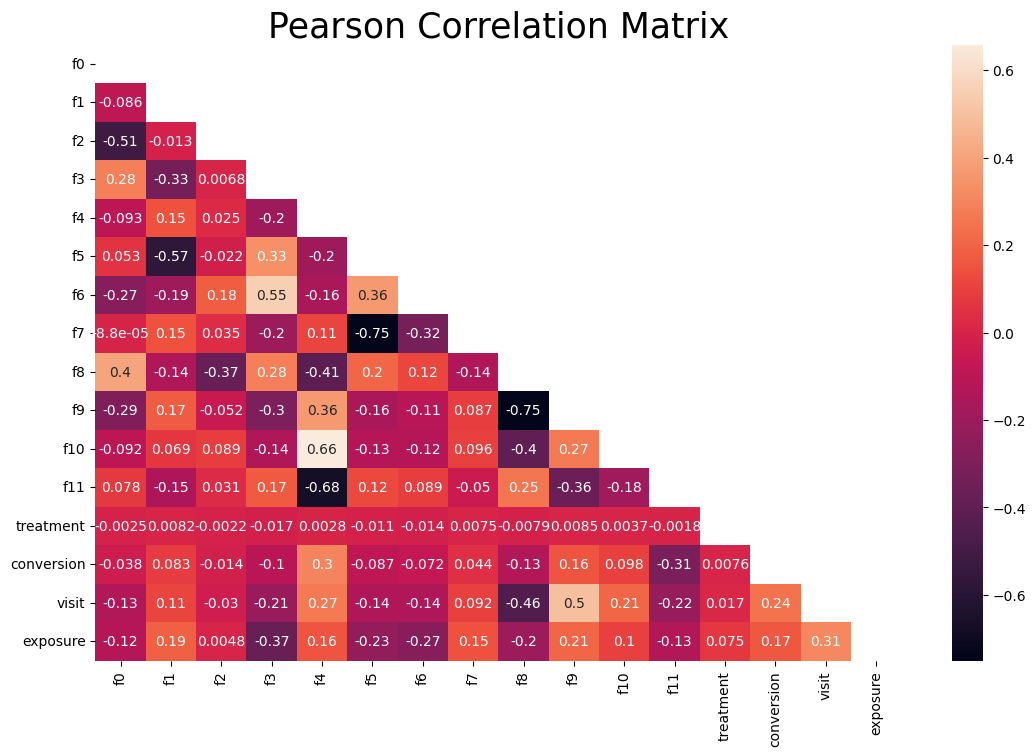

In [ ]:
#Correlation Matrix
f, ax = plt.subplots(figsize=(13, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, mask = mask)

In [ ]:
df.drop(columns=['f5','f8'],inplace = True)

In [ ]:
df['conversion'].value_counts().plot.bar()

* ÎåÄÏ°∞Íµ∞Ïùò Í≤ΩÏö∞ ÏïÑÏòà ÎßàÏºÄÌåÖÎÖ∏Ï∂úÏù¥ ÏïàÎêòÏóàÍ≥†, Ïã§ÌóòÍµ∞Ïùò Í≤ΩÏö∞ ÎÖ∏Ï∂úÏù¥ÎêúÍ≤ΩÏö∞ÏôÄ ÏïàÎêúÍ≤ΩÏö∞Í∞Ä ÎÇòÎà†Ï†∏ ÏûàÎã§.

* ÎåÄÏ°∞Íµ∞ ÎÖ∏Ï∂ú x
* Ïã§ÌóòÍµ∞ ÎÖ∏Ï∂ú x
* Ïã§ÌóòÍµ∞ ÎÖ∏Ï∂ú o

Ï¥ù 3Í∞ÄÏßÄ

Ïã§ÌóòÍµ∞(treatment=1) Í∑∏Î¶¨Í≥† ÎßàÏºÄÌåÖ ÎÖ∏Ï∂úÏù¥ ÏôÑÎ≤ΩÌûà ÏïàÎêúÍ≤ΩÏö∞ (exposure = 0) Ïò§ÌûàÎ†§ ÎåÄÏ°∞Íµ∞ Î≥¥Îã§ Ï†ÑÌôòÏú®Ïù¥ Îñ®Ïñ¥ÏßÑÎã§. ÎÖ∏Ï∂úÏù¥ ÏôÑÎ≤ΩÌûà ÎêòÏñ¥ÏïºÏßÄ Ï†ÑÌôòÏú®Ïóê Ï∞®Ïù¥Í∞Ä ÏûàÎã§.

In [ ]:
table_conv = df.groupby(['treatment','exposure']).agg({'conversion':['mean','sum','count']})
table_conv

conversion                 
                         mean    sum     count
treatment exposure                            
0         0          0.001938   4063   2096937
1         0          0.001194  13680  11454443
          1          0.053784  23031    428212

In [ ]:
table_vis = df.groupby(['treatment','exposure']).agg({'visit':['mean','sum','count']})
table_vis

visit                  
                        mean     sum     count
treatment exposure                            
0         0         0.038201   80105   2096937
1         0         0.034861  399314  11454443
          1         0.414538  177510    428212

Î∞©Î¨∏Ïú®Ïùò Í≤ΩÏö∞ÎèÑ ÎßàÏ∞¨Í∞ÄÏßÄ . Ïã§ÌóòÍµ∞ + ÎßàÏºÄÌåÖÏù¥ ÏôÑÎ≤ΩÌïòÍ≤å ÎÖ∏Ï∂ú ÎêòÏóàÏùÑÎïå ÌÅ∞ ÏÉÅÏäπÌè≠Ïù¥ ÏûàÎã§.

# TEST
> Îëê ÏßëÎã®Ïùò Î™®ÎπÑÏú® Ï∞®Ïù¥Ïóê ÎåÄÌïú Í∞ÄÏÑ§ Í≤ÄÏ†ï

1.conversionÏ†ÑÌôòÏú®

* ÎåÄÏ°∞Íµ∞ Ïã§ÌóòÍµ∞(Ï†ÑÏ≤¥)Í∞ÑÏóê Ï∞®Ïù¥Í∞Ä ÏûàÎäîÏßÄ
* ÎåÄÏ°∞Íµ∞ Ïã§ÌóòÍµ∞(exposure =1 )Í∞ÑÏóê Ï∞®Ïù¥Í∞Ä ÏûàÎäîÏßÄ


2.visit Î∞©Î¨∏Ïú®
* ÎåÄÏ°∞Íµ∞ Ïã§ÌóòÍµ∞(Ï†ÑÏ≤¥)Í∞ÑÏóê Ï∞®Ïù¥Í∞Ä ÏûàÎäîÏßÄ
* ÎåÄÏ°∞Íµ∞ Ïã§ÌóòÍµ∞(exposure = 1 ) Í∞ÑÏóê Ï∞®Ïù¥Í∞Ä ÏûàÎäîÏßÄ

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Ï†ÑÏ≤¥ ÎåÄÏ°∞Íµ∞ Í≥º Ïã§ÌóòÍµ∞ Í∞ÑÏùò Ï∞®Ïù¥ (Ï†ÑÌôòÏú®)

proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].loc[:1],
                  nobs=table_conv.reset_index()[('conversion')]['count'].loc[:1])[1]



6.983951422749621e-165

In [ ]:
# Test between control and exposure group on conversion
#Get the two groups of data
proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].drop(1),
                  nobs=table_conv.reset_index()[('conversion')]['count'].drop(1))[1]



0.0

In [ ]:
#test between control and treatment group on visit
#Get the two groups of data

proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].loc[:1],
                  nobs=table_vis.reset_index()[('visit')]['count'].loc[:1])[1]


5.150161571101964e-128

In [ ]:
#Test between control and exposure group on visit
#Get the two groups of data
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].drop(1),
                  nobs=table_vis.reset_index()[('visit')]['count'].drop(1))[1]

0.0

> Í≤∞Í≥º) exposure ÌñàÏùÑ ÎñÑ , Î∞©Î¨∏Ïú®, Ï†ÑÌôòÏú® Î™®Îëê Ï∞®Ïù¥Í∞Ä ÏûàÍ≥†,  Ïú†ÏùòÏàòÏ§Ä 5%ÌïòÏóê  Ïú†ÏùòÌôïÎ•† pÍ∞íÏù¥ 0.05Î≥¥Îã§ ÏûëÏùå, Ïú†ÏùòÎØ∏Ìïú Ï∞®Ïù¥Í∞Ä ÏûàÎã§Í≥† Î≥º Ïàò ÏûàÎã§.

> ÏóÖÎ¶¨ÌîÑÌåÖ Î™®Îç∏ÏùÑ Ï†ÅÏö©ÌïòÍ∏∞Ï†Ñ Ìï¥Îãπ ÎßàÏºÄÌåÖÏù¥ Ìö®Í≥ºÍ∞Ä ÏûàÎäîÍ≤ÉÏùÑ Í≤ÄÏ¶ù ÌñàÎã§!


Î≥µÍ∑ÄÏó¨Î∂ÄÎ•º visit ÏúºÎ°ú Î≥º Í±∞ÎÉê, conversion ÏúºÎ°ú Î≥º Í±∞ÎÉê  y Í∞íÏùÑ Ï†ïÌï¥Ï§òÏïºÌïúÎã§. Î®ºÏ†Ä visit ÏùÑ y Í∞íÏúºÎ°ú Î≥¥Í≥† ÏóÖÎ¶¨ÌîÑÌåÖ Î™®Îç∏ÏùÑ ÏßÑÌñâÌï¥Î≥¥Ïûê.

* Í¥ëÍ≥† Ï≤òÏßÄÍ∞Ä Ïù¥Î§ÑÏ°åÏùÑ ÎïåÏùò Ï†ÑÌôòÏó¨Î∂Ä  = target Î™®Îç∏ = treatment Ï§ëÏóêÏÑú visit Ïùò Í≤∞Í≥º

* Í¥ëÍ≥† Ï≤òÏπòÏôÄ Í¥ÄÍ≥ÑÏóÜÏù¥ ÏûêÏó∞ Ï†ÑÌôòÏó¨Î∂Ä = control Î™®Îç∏ = treatment = 0 Ï§ëÏóêÏÑú visitÏùò Í≤∞Í≥º



In [ ]:
# mask = df[(df['treatment'] == 1 ) & (df['exposure']==0)]
# df_ml = df.drop(mask.index).reset_index().drop(['index','treatment'], axis = 1)

# df_ml.sample(50)

df_visit = df.drop(columns=['conversion'])
# df_visit



# undersampling
* treatment ÌÉÄÍ≤üÎ≥ÄÏàòÏùò Î∂àÍ∑†Ìòï

Îç∞Ïù¥ÌÑ∞(13M rows) Í∞Ä ÍΩ§ ÌÅ¨Í∏∞ ÎïåÎ¨∏Ïóê undersampling ÏùÑ Ìï¥Ï£ºÎäîÍ≤å Îçî Ï¢ãÏùÑÎìØÌïòÎã§.

> ‚úîÔ∏è Ïã§Ìóò Í∑∏Î£πÍ≥º ÎåÄÏ°∞ Í∑∏Î£πÏùò Î∂ÑÌè¨Í∞Ä Í∑†ÌòïÏùÑ Ïù¥Î£®ÏßÄ ÏïäÏùÑ Îïå, Îç∞Ïù¥ÌÑ∞ Î¶¨Ïõ®Ïù¥ÌåÖÍ≥º Î¶¨ÏÉòÌîåÎßÅÏùÑ ÌÜµÌï¥ Í∑†ÌòïÏùÑ ÎßûÏ∂ú Ïàò ÏûàÎã§.  

Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

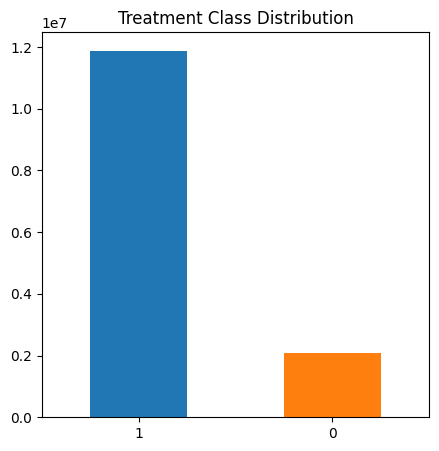

In [ ]:
fig = plt.figure(figsize = (5,5))
target_count = df['treatment'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 10)
plt.xticks(rotation=0)

Ïñ∏ÎçîÏÉòÌîåÎßÅ ÌïòÍ∏∞Ï†ÑÏóê Îç∞Ïù¥ÌÑ∞Î•º Ïôú ÎÇòÎà†Ï£ºÏñ¥Ïïº ÌïòÏßÄ?

>‚úîÔ∏è Î™®Îç∏ ÌèâÍ∞ÄÏùò ÏùºÎ∞òÏÑ±ÏùÑ Î≥¥Ïû•ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú
Ïñ∏ÎçîÏÉòÌîåÎßÅÏùÑ ÌÜµÌï¥ Îç∞Ïù¥ÌÑ∞Ïùò Î∂àÍ∑†ÌòïÏùÑ Ìï¥Í≤∞ÌïòÎ©¥, ÌïôÏäµÌïú Î™®Îç∏ÏùÄ Ìï¥Îãπ Îç∞Ïù¥ÌÑ∞Ïùò Î∂ÑÌè¨ÏôÄ Ï°∞Í±¥Ïóê ÌäπÌôîÎê† Ïàò ÏûàÏäµÎãàÎã§. Îî∞ÎùºÏÑú Ïù¥Îü¨Ìïú Î™®Îç∏ÏùÑ ÏùºÎ∞òÌôîÌïòÎ†§Î©¥ ÏõêÎûò Îç∞Ïù¥ÌÑ∞Ïùò Î∂ÑÌè¨Î•º Î∞òÏòÅÌïòÎäî ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÏó¨ Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï¥Ïïº ÌïúÎã§Í≥† ÌïúÎã§.

and Îç∞Ïù¥ÌÑ∞Ïùò ÎàÑÏÑ§ÏùÑ Î∞©ÏßÄÌï† Ïàò ÏûàÎã§.

> ‚úîÔ∏è train ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏóêÎßå ÏÉòÌîåÎßÅÏùÑ Ï†ÅÏö©Ìï¥Ï§òÏïºÌïúÎã§.
ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º Ïñ∏ÎçîÏÉòÌîåÎßÅÌïòÏó¨ ÌÅ¥ÎûòÏä§ Î∂àÍ∑†ÌòïÏùÑ Ìï¥Í≤∞ÌïòÎ©¥, ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏÑ±Îä• ÌèâÍ∞ÄÎäî ÌòÑÏã§Ï†ÅÏù¥Í≥† Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî Í≤∞Í≥ºÎ•º ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Îäî Ïã§Ï†ú ÏÑ∏Í≥ÑÏóêÏÑúÏùò Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨Î•º Ïûò ÎåÄÌëúÌï¥Ïïº ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê Ïñ∏ÎçîÏÉòÌîåÎßÅÏùÄ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê Ï†ÅÏö©ÌïòÏßÄ ÏïäÏäµÎãàÎã§.



In [ ]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])


In [ ]:
def random_under(df:pd.DataFrame, feature):

    target = df[feature].value_counts()

    if target.values[0]<target.values[1]:
        under = target.index.values[1]

    else:
        under = target.index.values[0]

    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]

    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)

    return df_1

train = random_under(train, 'treatment')

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy = 'majority')

X_train_resampled, y_train_resampled = undersample.fit_resample(train.drop(columns=['treatment']), train['treatment']) # x : target Ïù¥Ïô∏Ïùò Î≥ÄÏàòÎì§ , y: treatment

# Ïñ∏ÎçîÏÉòÌîåÎßÅÎêú Îç∞Ïù¥ÌÑ∞Î°úÎ∂ÄÌÑ∞ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
train = pd.DataFrame(X_train_resampled, columns=train.drop(columns=['treatment']).columns)
train['treatment'] = y_train_resampled

<Axes: title={'center': 'Treatment Class Distribution'}>

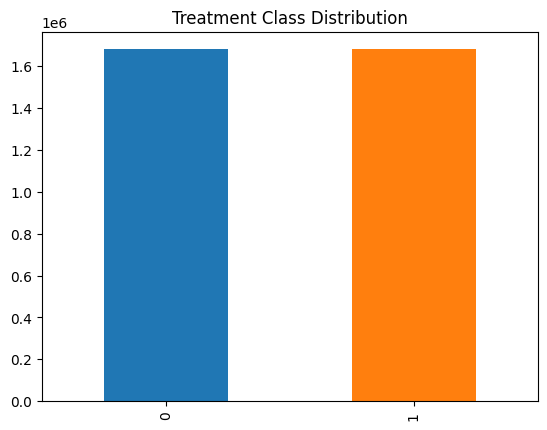

In [ ]:
# Ïñ∏ÎçîÏÉòÌîåÎßÅ ÌõÑÏùò ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ÌôïÏù∏
target_count_resampled = train['treatment'].value_counts()
target_count_resampled.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 10)

1    11882655
0     2096937
Name: treatment, dtype: int64

# uplifting score

exposure Í≥º treatment Í∞Ä Í∞ôÎã§Í≥† Î≥¥Î©¥ÎêúÎã§. Îç∞Ïù¥ÌÑ∞Í∞Ä Ï¢Ä Ìó∑Í∞àÎ¶¨Í≤å Î™ÖÏãú ÎêòÏñ¥ÏûàÎã§. treatment Í∞Ä 1Ïù∏ Í≤ΩÏö∞ ÎßàÏºÄÌåÖÏùÑ Î∞õÏùÄÍ±∞Í≥†, 0 Ïù∏Í≤ΩÏö∞ ÎßàÏºÄÌåÖÏùÑ Î∞õÏßÄ ÏïäÏùÄÍ≤ÉÏù¥Îã§.
exposure Ïùò Í≤ΩÏö∞ÎèÑ Í¥ëÍ≥† ÎÖ∏Ï∂úÏù¥ ÎêúÍ≤ΩÏö∞ 1 , ÏïÑÎãåÍ≤ΩÏö∞ 0 Ïù¥Îã§. Í≤∞Íµ≠ ÏóÖÎ¶¨ÌîÑÌåÖ 4Î∂ÑÎ©¥ÏùÑ ÎÇòÎàåÎïå Îî∞Î°ú Î¥êÏïºÌïúÎã§. ÏùºÎã® treatment Í∏∞Ï§ÄÏúºÎ°ú Î≥¥Ïûê.

ÏùºÎã® ÏúÑ Îç∞Ïù¥ÌÑ∞ÏóêÎäî Ï†ÑÌôò Ïù¥ÎùºÍ≥† Î≥º Ïàò ÏûàÎäî Î≥ÄÏàòÍ∞Ä ÎëêÍ∞ÄÏßÄ ÏûàÏùå.(Ï†ÑÌôòÍ∏∞Ï§ÄÏùÑ Î¨¥ÏóáÏúºÎ°ú Î≥ºÍ≤ÉÏù∏Í∞Ä.. ) visit Í≥º conversion

Î®ºÏ†Ä, ***visit*** ÏùÑ Ï†ÑÌôòÍ∏∞Ï§ÄÏù¥Îùº Î≥¥Í≥† uplifing scoreÎ•º Íµ¨Ìï¥Î≥¥Ïûê!

In [ ]:
train.sample(50)

In [ ]:
def target_class(df, treatment, target):

    #CN:
    df['target_class'] = 0
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3
    return df

In [ ]:
# Î∞©Î¨∏ÏùÑ Ï†ÑÌôò Í∏∞Ï§ÄÏúºÎ°ú Î≥¥Í≥†, Îã§Î•∏ Í∏∞Ï§ÄÎì§ conversion, exposureÏùÄ ÎπºÏ§ÄÎã§
train = target_class(train.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')
test = target_class(test.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')



In [ ]:
test = test[~test['target_class'].isin([238, 422099, 1093119])]


In [ ]:
test['target_class'].unique()


array([0, 2, 3, 1])

In [ ]:
# Ï£ºÏñ¥ÏßÑ ÌîºÏ≤ò Î¶¨Ïä§Ìä∏
features = ['f0', 'f1', 'f2', 'f3', 'f4','f5', 'f6', 'f7','f8' ,'f9', 'f10']

# ÌîºÏ≤ò Î∞è ÌÉÄÍ≤üÏùÑ ÏÑ§Ï†ïÌïòÍ≥† Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÌï†
X = train[features]  # train Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌîºÏ≤ò Ï∂îÏ∂ú
y = train['target_class']
treatment = train['treatment']

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

In [ ]:
!pip install scikit-uplift

In [ ]:
!pip install catboost

In [ ]:
X_val

f0         f1        f2        f3         f4        f5  \
12610298  24.915182  10.059654  8.214383  4.679882  10.280525  3.013064   
6224579   26.110053  10.059654  8.214383  4.679882  10.280525  4.115453   
10471916  12.616365  10.059654  8.541917  4.679882  10.280525  4.115453   
5693068   25.949422  10.059654  8.214383  4.679882  10.280525  4.115453   
569749    26.096864  10.059654  8.214383  4.679882  10.280525  4.115453   
...             ...        ...       ...       ...        ...       ...   
6353762   25.829773  10.059654  8.214383  4.679882  10.280525  4.115453   
12283918  21.524531  10.059654  8.214383  4.679882  10.280525  4.115453   
5138434   12.616365  10.059654  8.910652  4.679882  10.280525  4.115453   
12787331  25.545864  10.059654  8.214383  4.679882  10.280525  4.115453   
6231064   24.218570  10.059654  8.214383  4.679882  10.280525  4.115453   

                f6         f7        f8         f9       f10  
12610298 -5.116672  11.391382  3.971858  13.190056  5.300375  
6224579  -5.987667   4.833815  3.971858  13.190056  5.300375  
10471916  0.294443   4.833815  3.943716  18.380112  5.300375  
5693068  -1.288207   4.833815  3.971858  13.190056  5.300375  
569749   -5.576414   4.833815  3.971858  13.190056  5.300375  
...            ...        ...       ...        ...       ...  
6353762  -1.288207   4.833815  3.971858  13.190056  5.300375  
12283918 -8.883666   4.833815  3.971858  13.190056  5.300375  
5138434   0.294443   4.833815  3.884971  13.190056  5.300375  
12787331 -5.576414   4.833815  3.971858  13.190056  5.300375  
6231064  -9.238756   4.833815  3.971858  13.190056  5.300375  

[671020 rows x 11 columns]

In [ ]:
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

models_results = {
    'approach': [],
    'uplift@30%': []
}

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss'
}

# TwoModels Î™®Îç∏ ÏÑ§Ï†ï
tm = TwoModels(
    estimator_trmnt=lgb.LGBMClassifier(**lgb_params),
    estimator_ctrl=lgb.LGBMClassifier(**lgb_params),
    method='vanilla'
)

# 3. Î™®Îç∏ ÌïôÏäµ
tm = tm.fit(
    X_train, y_train, treat_train
)

# 4. ÏóÖÎ¶¨ÌîÑÌåÖ ÏòàÏ∏°
uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

# 5. ÏóÖÎ¶¨ÌîÑÌåÖ Ï∏°Ï†ï
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);


In [ ]:
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']


X_train, y_train, treat_train,X_val


In [ ]:
from sklearn.preprocessing import LabelEncoder

# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏôÄ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
train_labels = train['target_class']
test_labels = test['target_class']

# LabelEncoder Ï¥àÍ∏∞Ìôî Î∞è ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Í∞Å Î†àÏù¥Î∏î Í∞íÍ≥º classes_ ÎπÑÍµê
unseen_labels = [label for label in test_labels if label not in label_encoder.classes_]
print("Unseen labels in test:", unseen_labels)

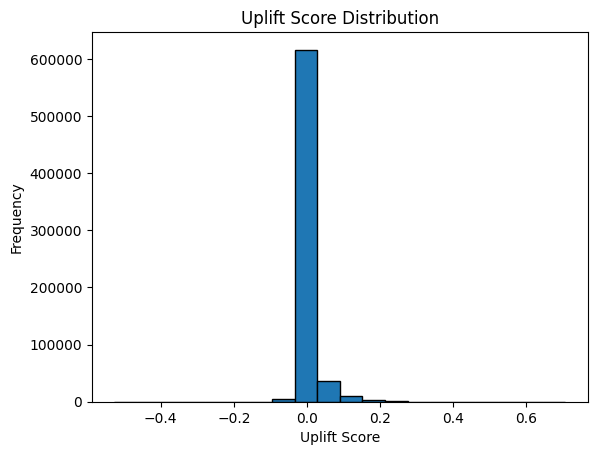

In [ ]:
plt.hist(uplift_tm, bins=20, edgecolor='black')
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Uplift Score Distribution')
plt.show()

In [ ]:
# uplift_tmÏùÑ Numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
df_uplift = pd.DataFrame({'uplift_score': np.array(uplift_tm)})
df_uplift

uplift_score
0           0.000442
1           0.000187
2           0.002777
3           0.000226
4           0.000172
...              ...
671015      0.000214
671016     -0.001051
671017      0.000199
671018      0.000884
671019      0.000030

[671020 rows x 1 columns]

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

approach  uplift@30%
0  TwoModels    0.033306